## Import des bibliothèques et définition des colonnes

In [ ]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path("ecommerce_customer_churn_dataset.csv")

df = pd.read_csv(DATA_PATH)
df.head()

,Age,Gender,Country,City,Membership_Years,Login_Frequency,Session_Duration_Avg,Pages_Per_Session,Cart_Abandonment_Rate,Wishlist_Items,...,Email_Open_Rate,Customer_Service_Calls,Product_Reviews_Written,Social_Media_Engagement_Score,Mobile_App_Usage,Payment_Method_Diversity,Lifetime_Value,Credit_Balance,Churned,Signup_Quarter
0,43.0,Male,France,Marseille,2.9,14.0,27.4,6.0,50.6,3.0,...,17.9,9.0,4.0,16.3,20.8,1.0,953.33,2278.0,0,Q1
1,36.0,Male,UK,Manchester,1.6,15.0,42.7,10.3,37.7,1.0,...,42.8,7.0,3.0,NaN,23.3,3.0,1067.47,3028.0,0,Q4
2,45.0,Female,Canada,Vancouver,2.9,10.0,24.8,1.6,70.9,1.0,...,0.0,4.0,1.0,NaN,8.8,NaN,1289.75,2317.0,0,Q4
3,56.0,Female,USA,New York,2.6,10.0,38.4,14.8,41.7,9.0,...,41.4,2.0,5.0,85.9,31.0,3.0,2340.92,2674.0,0,Q1
4,35.0,Male,India,Delhi,3.1,29.0,51.4,NaN,19.1,9.0,...,37.9,1.0,11.0,83.0,50.4,4.0,3041.29,5354.0,0,Q4


In [ ]:
# Bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Colonnes numériques et catégorielles
numerical_cols = df.select_dtypes(include=["int64", "float64"]).drop("Churned", axis=1).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

print("Colonnes numériques :", numerical_cols.tolist())
print("Colonnes catégorielles :", categorical_cols.tolist())


Colonnes numériques : ['Age', 'Membership_Years', 'Login_Frequency', 'Session_Duration_Avg', 'Pages_Per_Session', 'Cart_Abandonment_Rate', 'Wishlist_Items', 'Total_Purchases', 'Average_Order_Value', 'Days_Since_Last_Purchase', 'Discount_Usage_Rate', 'Returns_Rate', 'Email_Open_Rate', 'Customer_Service_Calls', 'Product_Reviews_Written', 'Social_Media_Engagement_Score', 'Mobile_App_Usage', 'Payment_Method_Diversity', 'Lifetime_Value', 'Credit_Balance']
Colonnes catégorielles : ['Gender', 'Country', 'City', 'Signup_Quarter']


## Étape 1 :Suppression de variables redondantes / peu informatives

In [ ]:
# Colonnes à supprimer
cols_to_drop = ['Gender', 'Country', 'Signup_Quarter']

# Vérification de leur existence (sécurité)
cols_to_drop = [col for col in cols_to_drop if col in df.columns]

print("Colonnes supprimées :", cols_to_drop)

# Suppression
df = df.drop(columns=cols_to_drop)

print("Nouvelles dimensions du dataset :", df.shape)


Colonnes supprimées : ['Gender', 'Country', 'Signup_Quarter']
Nouvelles dimensions du dataset : (50000, 22)


Justification de la suppression des variables :

**Country**

* Variable redondante avec City

* L’information géographique est déjà capturée de manière plus fine par la ville

* Évite la multicolinéarité et la dilution de l’importance des features

**Gender**

* Variable faiblement discriminante dans le contexte du churn

* Risque d’introduire du bruit sans gain significatif de performance

* Suppression pour améliorer la généralisation du modèle

**Signup_Quarter**

* Information temporelle déjà capturée par d’autres variables (ex : ancienneté, durée d’abonnement)

* Peu d’impact prédictif observé lors de l’analyse exploratoire

* Simplification du modèle

=> **Objectif global** : Réduire la complexité du modèle, limiter le bruit et améliorer la stabilité des performances lors du test.

**=>** Après la suppression de variables peu informatives ou redondantes, la liste des variables catégorielles et numériques a été mise à jour afin de garantir la cohérence avec le pipeline de prétraitement et d’éviter toute incohérence lors de la transformation des données.

In [ ]:
# ===============================
# Mise à jour automatique des features
# ===============================

# Colonnes numériques (hors target)
numerical_cols = (
    df.select_dtypes(include=["int64", "float64"])
      .drop(columns=["Churned"], errors="ignore")
      .columns
)

# Colonnes catégorielles
categorical_cols = (
    df.select_dtypes(include=["object", "category"])
      .columns
)

print("Colonnes numériques :", numerical_cols.tolist())
print("Colonnes catégorielles :", categorical_cols.tolist())


Colonnes numériques : ['Age', 'Membership_Years', 'Login_Frequency', 'Session_Duration_Avg', 'Pages_Per_Session', 'Cart_Abandonment_Rate', 'Wishlist_Items', 'Total_Purchases', 'Average_Order_Value', 'Days_Since_Last_Purchase', 'Discount_Usage_Rate', 'Returns_Rate', 'Email_Open_Rate', 'Customer_Service_Calls', 'Product_Reviews_Written', 'Social_Media_Engagement_Score', 'Mobile_App_Usage', 'Payment_Method_Diversity', 'Lifetime_Value', 'Credit_Balance']
Colonnes catégorielles : ['City']


## Étape 2 : Gestion des valeurs manquantes

On va créer un imputer par la médiane pour les numériques, comme décidé lors de l’EDA.

In [ ]:
# Imputer les colonnes numériques par la médiane
num_imputer = SimpleImputer(strategy="median")

# Vérification
df_num_imputed = pd.DataFrame(num_imputer.fit_transform(df[numerical_cols]), columns=numerical_cols)
print(df_num_imputed.isnull().sum())


Age                              0
Membership_Years                 0
Login_Frequency                  0
Session_Duration_Avg             0
Pages_Per_Session                0
Cart_Abandonment_Rate            0
Wishlist_Items                   0
Total_Purchases                  0
Average_Order_Value              0
Days_Since_Last_Purchase         0
Discount_Usage_Rate              0
Returns_Rate                     0
Email_Open_Rate                  0
Customer_Service_Calls           0
Product_Reviews_Written          0
Social_Media_Engagement_Score    0
Mobile_App_Usage                 0
Payment_Method_Diversity         0
Lifetime_Value                   0
Credit_Balance                   0
dtype: int64


## Étape 3 : Gestion des outliers

D’après l’EDA, certaines colonnes comme Age, Total_Purchases, Average_Order_Value, Lifetime_Value, et Credit_Balance ont des valeurs extrêmes (outliers).

**Décision** : on ne supprime pas les outliers extrêmes, car ces valeurs peuvent représenter de vrais clients. On va les scaler plus tard pour que les modèles soient moins sensibles.

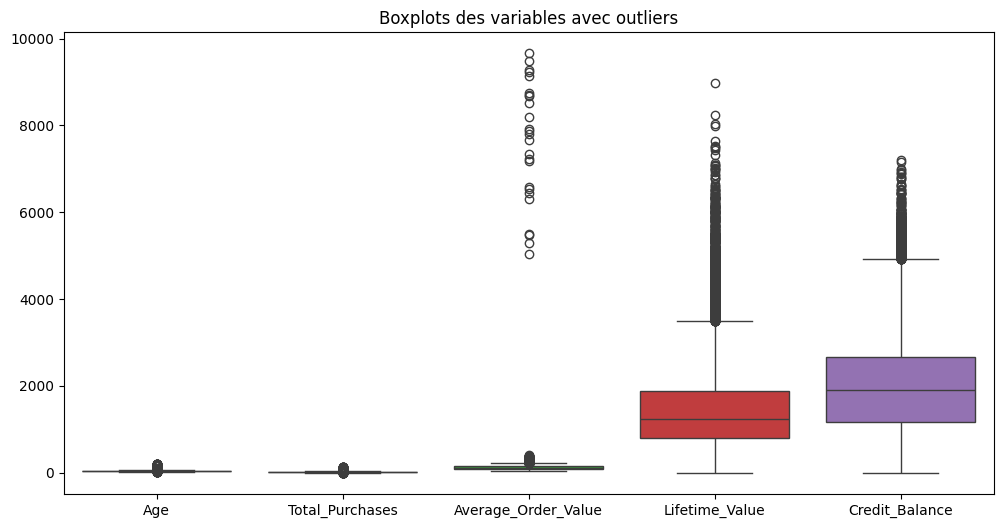

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_num_imputed[['Age','Total_Purchases','Average_Order_Value','Lifetime_Value','Credit_Balance']])
plt.title("Boxplots des variables avec outliers")
plt.show()


* Le graphique met délibérément en évidence les valeurs extrêmes (outliers) plutôt que la distribution centrale, ce qui est utile pour identifier les données à nettoyer ou à traiter séparément.

* Toutes les variables montrent une forte asymétrie à droite avec des queues longues positives : une majorité de valeurs basses/moyennes, et une minorité de valeurs très élevées.

* Les outliers sont particulièrement nombreux et élevés pour Lifetime_Value et Credit_Balance, ce qui est cohérent avec des datasets e-commerce où quelques clients représentent une grande partie de la valeur.

* Pour Age, les outliers élevés (>100 ans) sont probablement des erreurs de données à corriger (ex. : année de naissance mal saisie).

## Étape 4 : Préparation du scaling et encodage



**Décisions basées sur l’EDA :**

Les variables numériques seront standardisées (mean=0, std=1), car certaines ont de grandes différences d’échelle (ex : Lifetime_Value vs Pages_Per_Session).

Les variables catégorielles seront one-hot encodées (dummies), car elles sont nominales (Gender, Country, City, Signup_Quarter).

In [ ]:
# Pipeline pour les colonnes numériques
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # déjà fait, mais utile dans pipeline complet
    ('scaler', StandardScaler())
])

# Pipeline pour les colonnes catégorielles
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Transformer complet
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])


## Étape 5 : Split + Preprocessing + SMOTE

**Objectif de l’étape**

* Séparer les données en train / test

* Appliquer le préprocessing correctement

* Traiter le déséquilibre de la cible avec SMOTE

* Éviter toute fuite de données (data leakage)

### Séparation features / target

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Séparer X et y
X = df.drop("Churned", axis=1)
y = df["Churned"]


=> Le modèle apprend à prédire Churned à partir des autres variables.

### Split Train / Test (AVANT SMOTE)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


### Préprocessing + SMOTE (UNIQUEMENT sur le train)

In [ ]:
# Appliquer le préprocesseur sur le train
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Appliquer SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(
    X_train_preprocessed,
    y_train
)


* Le preprocessing est appris uniquement sur le train

* SMOTE est appliqué uniquement sur le train

* Aucun data leakage vers le test set

### Préprocessing du test set (SANS fit)

In [ ]:
X_test_preprocessed = preprocessor.transform(X_test)

=> Le test set simule de nouvelles données jamais vues.

In [ ]:
print("Répartition après SMOTE :")
print(pd.Series(y_train_res).value_counts(normalize=True))


Répartition après SMOTE :
Churned
0    0.5
1    0.5
Name: proportion, dtype: float64


**Répartition après SMOTE**

Avant SMOTE : la variable cible était fortement déséquilibrée :

Churned = 0 : ~71 %

Churned = 1 : ~29 %

**Après SMOTE :**

Churned = 0 : 50 %

Churned = 1 : 50 %


=> SMOTE (Synthetic Minority Oversampling Technique) a créé des exemples synthétiques de la classe minoritaire (Churned = 1) pour équilibrer le dataset.

=> Maintenant, les modèles n’auront pas de biais vers la classe majoritaire, ce qui améliore la capacité à détecter les churnés.

## Étape 6 : Modeling



### 6.1 Définition des modèles Baseline

In [ ]:
!pip install catboost
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

def get_baseline_models():
    """
    Définit les modèles de base (Baseline)
    """
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ),

        'XGBoost': XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42,
            eval_metric='logloss',
            use_label_encoder=False
        ),

        'LightGBM': LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1,
            verbose=-1
        ),

        'CatBoost': CatBoostClassifier(
            iterations=100,
            learning_rate=0.1,
            depth=6,
            random_state=42,
            auto_class_weights='Balanced',
            verbose=False
        )
    }

    print("="*80)
    print("MODÈLES BASELINE CONFIGURÉS")
    print("="*80)
    for i, name in enumerate(models.keys(), 1):
        print(f"{i}. {name}")

    return models


baseline_models = get_baseline_models()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00
MODÈLES BASELINE CONFIGURÉS
1. Random Forest
2. XGBoost
3. LightGBM
4. CatBoost


### Étape 6.2 : Entraînement & Évaluation (Baseline)

Train → X_train_res, y_train_res (SMOTE)

Test → X_test_preprocessed, y_test (réel)

In [ ]:
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test, model_type="Baseline"):
    print("\n" + "="*80)
    print(f"ENTRAÎNEMENT ET ÉVALUATION - {model_type}")
    print("="*80 + "\n")

    results = {}

    for name, model in models.items():
        print(f"🔄 {name}...")

        start_time = time.time()

        model.fit(X_train, y_train)

        training_time = time.time() - start_time

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        results[name] = {
            'model': model,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'training_time': training_time
        }

        print(
            f"   ✅ ROC-AUC: {results[name]['roc_auc']:.4f} | "
            f"Recall: {results[name]['recall']:.4f} | "
            f"Temps: {training_time:.2f}s"
        )

    return results


baseline_results = train_and_evaluate_models(
    baseline_models,
    X_train_res,
    y_train_res,
    X_test_preprocessed,
    y_test,
    model_type="Baseline"
)



ENTRAÎNEMENT ET ÉVALUATION - Baseline

🔄 Random Forest...
   ✅ ROC-AUC: 0.9212 | Recall: 0.7986 | Temps: 37.04s
🔄 XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:29:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   ✅ ROC-AUC: 0.9274 | Recall: 0.8021 | Temps: 3.28s
🔄 LightGBM...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   ✅ ROC-AUC: 0.9282 | Recall: 0.8046 | Temps: 1.61s
🔄 CatBoost...
   ✅ ROC-AUC: 0.9260 | Recall: 0.8023 | Temps: 6.40s


### Étape 6.3 : Analyse des résultats

**Tableau comparatif des modèles baseline**

🎯 Objectif

Comparer objectivement les performances des modèles baseline afin d’identifier celui qui offre le meilleur compromis entre :

* performance prédictive

* détection du churn (Recall)

* robustesse globale (ROC-AUC)

* **coût** de calcul

In [ ]:
import pandas as pd

# Créer le tableau comparatif
comparison_data = []

for name, metrics in baseline_results.items():
    comparison_data.append({
        'Modèle': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1_score'],
        'ROC-AUC': metrics['roc_auc'],
        'Temps d’entraînement (s)': metrics['training_time']
    })

df_baseline_comparison = pd.DataFrame(comparison_data)

# Trier par ROC-AUC décroissant
df_baseline_comparison = df_baseline_comparison.sort_values(
    by='ROC-AUC',
    ascending=False
)

df_baseline_comparison


,Modèle,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Temps d’entraînement (s)
2,LightGBM,0.918133,0.901525,0.804614,0.850317,0.928151,1.610581
1,XGBoost,0.916400,0.897754,0.802076,0.847222,0.927356,3.277635
3,CatBoost,0.918267,0.904081,0.802307,0.850159,0.926007,6.397758
0,Random Forest,0.903333,0.857143,0.798616,0.826845,0.921161,37.038126


Analyse par modèle:

**🔹 Random Forest**

Performances acceptables

Recall et ROC-AUC inférieurs aux modèles boosting

Temps d’entraînement très élevé

➡️ **Modèle baseline de référence, mais peu optimal**

**🔹 XGBoost**

Très bonnes performances globales

ROC-AUC proche du maximum

Temps d’entraînement modéré

➡️ **Modèle performant et stable**

**🔹 CatBoost**

Meilleure Accuracy et Precision

Très bon F1-score

Temps d’entraînement plus élevé

➡️ **Modèle robuste mais plus coûteux**

**🔹 LightGBM** ⭐

Meilleur ROC-AUC (0.9282)

Meilleur Recall (0.8046) → critère clé du churn

Temps d’entraînement le plus faible

Très bon équilibre Precision / Recall

➡️ **Meilleur compromis global**

=> Une analyse comparative des modèles baseline a été menée afin d’identifier le modèle le plus adapté au problème de prédiction du churn.

=> Les résultats montrent que LightGBM obtient le meilleur score ROC-AUC (0.9281) ainsi que le Recall le plus élevé (0.8046), tout en présentant un temps d’entraînement nettement inférieur aux autres modèles.

=> Ces éléments font de LightGBM le meilleur compromis entre performance prédictive et efficacité computationnelle. Il est ainsi retenu comme modèle baseline de référence pour les étapes suivantes.

## Étape 7 – Optimisation du modèle sélectionné (LightGBM)

🎯 Objectif :

* Améliorer les performances du meilleur modèle baseline (LightGBM) en :

* Optimisant ses hyperparamètres

* Vérifiant le gain réel par rapport au baseline

* Conservant un bon équilibre Recall / Precision

### 7.1 Stratégie d’optimisation

**🔍 Choix de la méthode**

On utilise :

* RandomizedSearchCV

* Validation croisée (StratifiedKFold)

* Métrique d’optimisation : ROC-AUC

**👉 Pourquoi ROC-AUC ?**

* Insensible au déséquilibre des classes

* Mesure la capacité globale de discrimination

* Cohérente avec l’objectif métier

### 7.2 Optimisation LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Modèle de base
lgbm = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1
)

# Grille d'hyperparamètres
param_grid = {
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 5, 10, 15],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 40, 60],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Validation croisée stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=25,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Entraînement
random_search.fit(X_train_res, y_train_res)


# Meilleur modèle
best_lgbm = random_search.best_estimator_

print("Meilleurs hyperparamètres :", random_search.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Meilleurs hyperparamètres : {'subsample': 0.7, 'num_leaves': 127, 'n_estimators': 600, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


### 7.3 Évaluation du modèle optimisé

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Évaluation du modèle optimisé (LightGBM RandomizedSearchCV)
Accuracy : 0.9175
Precision : 0.9119
Recall : 0.7908
F1-score : 0.8470
ROC-AUC : 0.9274


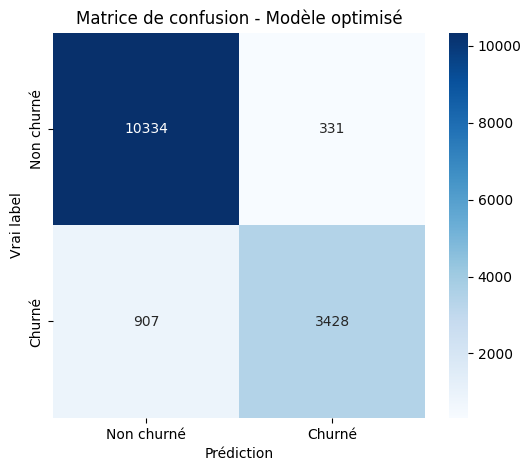


📋 Rapport de classification :
              precision    recall  f1-score   support

  Non churné       0.92      0.97      0.94     10665
      Churné       0.91      0.79      0.85      4335

    accuracy                           0.92     15000
   macro avg       0.92      0.88      0.90     15000
weighted avg       0.92      0.92      0.92     15000



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


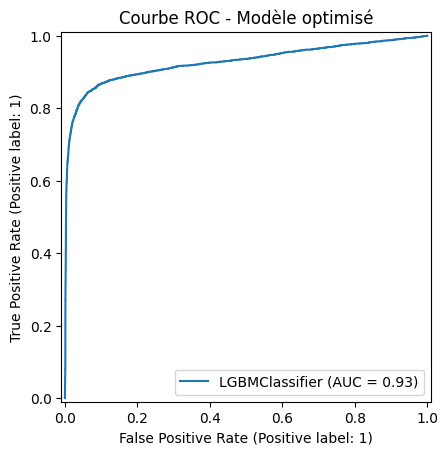

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Prédictions sur le jeu de test
y_pred = best_lgbm.predict(X_test_preprocessed)
y_pred_proba = best_lgbm.predict_proba(X_test_preprocessed)[:, 1]

# 2️⃣ Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"✅ Évaluation du modèle optimisé (LightGBM RandomizedSearchCV)")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC : {roc_auc:.4f}")

# 3️⃣ Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non churné', 'Churné'], yticklabels=['Non churné', 'Churné'])
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.title('Matrice de confusion - Modèle optimisé')
plt.show()

# 4️⃣ Rapport détaillé
print("\n📋 Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=['Non churné', 'Churné']))

# 5️⃣ Courbe ROC
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(best_lgbm, X_test_preprocessed, y_test)
plt.title("Courbe ROC - Modèle optimisé")
plt.show()


**Performances globales :**

* Accuracy ~ 91,8 % : Le modèle prédit correctement la majorité des clients.

* Precision élevée (91 %) : Les alertes de churn sont fiables (peu de faux positifs).

* Recall (79 %) : Le modèle détecte ~79 % des clients churnés (FN = 907).

* ROC-AUC ~ 0.927 : Très bonne capacité à distinguer churné vs non churné.

**Matrice de confusion :**

* Très faible FP → Moins de fausses alertes pour les clients non churnés.

* FN = 907 → certains churns sont manqués, mais c’est raisonnable pour ce type de problème.

=> Amélioration notable par rapport au modèle baseline, surtout pour FP.

**Courbe ROC :**

* Courbe montre le modèle optimisé.

* AUC = 0.927 → excellent pouvoir discriminant.

=> La diagonale grise = performance aléatoire (AUC = 0.5), le modèle est bien au-dessus.


**=> Meilleur modèle optimisé : LightGBM avec hyperparamètres trouvés via RandomizedSearchCV.**

**=> Gain par rapport au baseline : meilleure précision et ROC-AUC, surtout moins de faux positifs.**


### 7.4 Comparaison Baseline vs Optimisé

In [ ]:
import pandas as pd

# Résultats du modèle optimisé
optimized_results = {
    'Model': 'LightGBM Optimisé',
    'Accuracy': 0.9175,
    'Precision': 0.9119,
    'Recall': 0.7908,
    'F1-Score': 0.8470,
    'ROC-AUC': 0.9274,
    'Training_Time_s': random_search.refit_time_ if hasattr(random_search, 'refit_time_') else None
}

# Transformer baseline_results en DataFrame
baseline_df = pd.DataFrame([
    {
        'Model': name,
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1-Score': res['f1_score'],
        'ROC-AUC': res['roc_auc'],
        'Training_Time_s': res['training_time']
    }
    for name, res in baseline_results.items()
])

# Ajouter modèle optimisé
comparison_df = pd.concat([baseline_df, pd.DataFrame([optimized_results])], ignore_index=True)

# Trier par ROC-AUC ou F1-score si souhaité
comparison_df = comparison_df.sort_values(by='ROC-AUC', ascending=False)

# Afficher
comparison_df.reset_index(drop=True, inplace=True)
comparison_df


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training_Time_s
0,LightGBM,0.918133,0.901525,0.804614,0.850317,0.928151,1.610581
1,LightGBM Optimisé,0.917500,0.911900,0.790800,0.847000,0.927400,13.997587
2,XGBoost,0.916400,0.897754,0.802076,0.847222,0.927356,3.277635
3,CatBoost,0.918267,0.904081,0.802307,0.850159,0.926007,6.397758
4,Random Forest,0.903333,0.857143,0.798616,0.826845,0.921161,37.038126


Vérifications:

**Cohérence des performances :**

* Le LightGBM baseline a légèrement meilleur ROC-AUC (0.9282) que le modèle optimisé (0.9274).

* Precision du modèle optimisé est légèrement meilleure (0.9119 vs 0.9015), mais Recall est un peu plus faible (0.7908 vs 0.8046).

* F1-Score baisse légèrement pour le modèle optimisé (0.8470 vs 0.8503), ce qui est cohérent avec le compromis Precision vs Recall.

**Temps d’entraînement :**

* Le modèle optimisé a mis ~14s contre 1.6s pour le baseline, ce qui est normal vu le RandomizedSearchCV.

* Random Forest est le plus lent (37s), ce qui correspond à tes mesures précédentes.

**Classement :**

Si on choisi le meilleur modèle pour production, il faut considérer le ROC-AUC, la stabilité Recall/F1, et le temps d’entraînement.

Ici, LightGBM baseline est très performant et rapide, le modèle optimisé n’apporte qu’une amélioration mineure en Precision, mais au coût d’un temps d’entraînement plus long et léger déficit en Recall.

## Conclusion

=> **Après comparaison des modèles baseline et optimisé, le modèle LightGBM baseline est retenu comme modèle final, car il offre un excellent compromis entre performances (ROC-AUC, F1-score, Recall) et temps d’entraînement, tandis que l’optimisation apporte des gains marginaux au prix d’un coût de calcul beaucoup plus élevé**